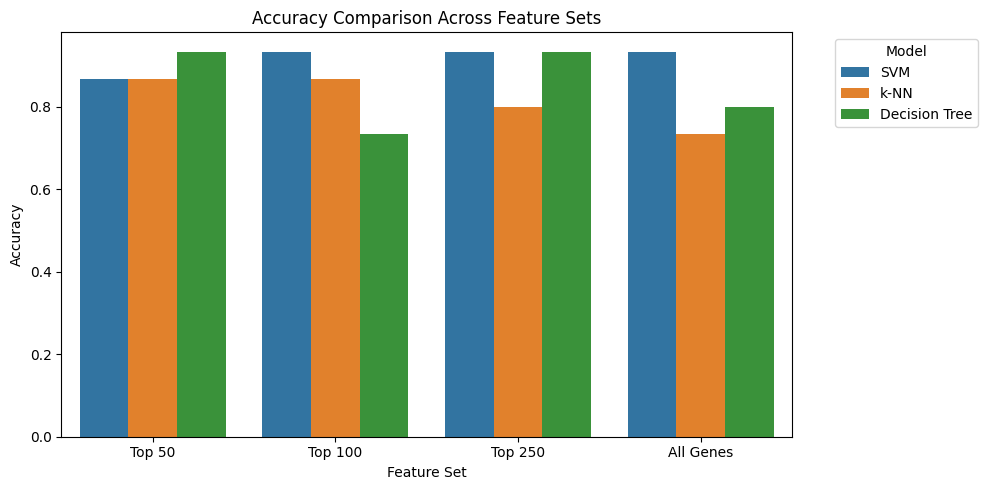

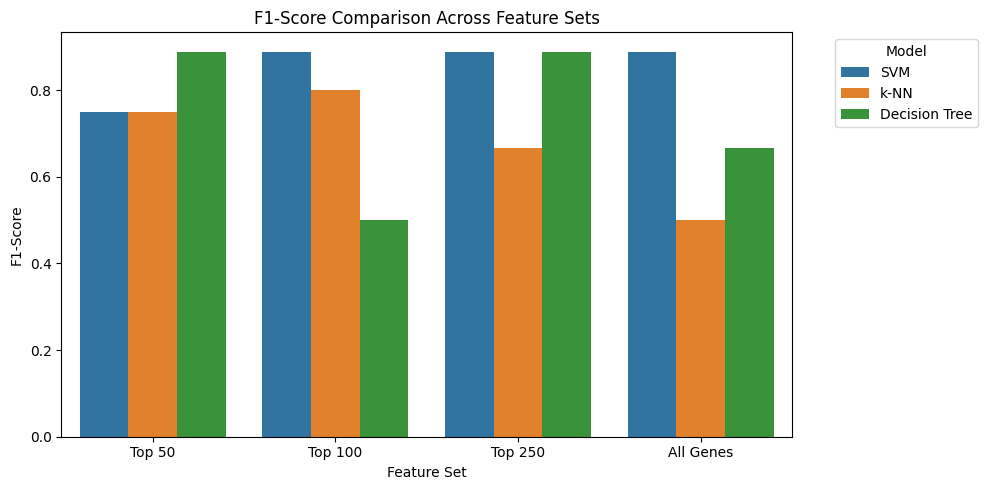

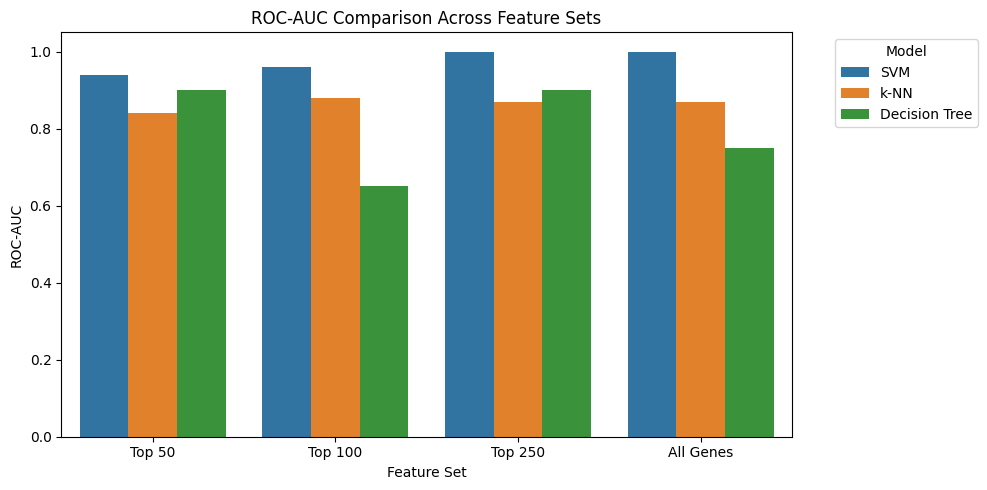


Confusion Matrix for SVM on Top 50 (Sample Size=15)
[[10  0]
 [ 2  3]]

Confusion Matrix for k-NN on Top 50 (Sample Size=15)
[[10  0]
 [ 2  3]]

Confusion Matrix for Decision Tree on Top 50 (Sample Size=15)
[[10  0]
 [ 1  4]]

Confusion Matrix for SVM on Top 100 (Sample Size=15)
[[10  0]
 [ 1  4]]

Confusion Matrix for k-NN on Top 100 (Sample Size=15)
[[9 1]
 [1 4]]

Confusion Matrix for Decision Tree on Top 100 (Sample Size=15)
[[9 1]
 [3 2]]

Confusion Matrix for SVM on Top 250 (Sample Size=15)
[[10  0]
 [ 1  4]]

Confusion Matrix for k-NN on Top 250 (Sample Size=15)
[[9 1]
 [2 3]]

Confusion Matrix for Decision Tree on Top 250 (Sample Size=15)
[[10  0]
 [ 1  4]]

Confusion Matrix for SVM on All Genes (Sample Size=15)
[[10  0]
 [ 1  4]]

Confusion Matrix for k-NN on All Genes (Sample Size=15)
[[9 1]
 [3 2]]

Confusion Matrix for Decision Tree on All Genes (Sample Size=15)
[[9 1]
 [2 3]]

Table: Classical ML Performance Across Feature Sets
| Feature Set   | Model         |   Accuracy

In [11]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Configuration
# ----------------------------
FEATURE_SETS_MAP = {
    'Top 50': {'X_train': 'X_train_top50.csv', 'y_train': 'y_train50.csv',
               'X_test': 'X_test_top50.csv', 'y_test': 'y_test50.csv'},
    'Top 100': {'X_train': 'X_train_top100.csv', 'y_train': 'y_train100.csv',
                'X_test': 'X_test_top100.csv', 'y_test': 'y_test100.csv'},
    'Top 250': {'X_train': 'X_train_top250.csv', 'y_train': 'y_train250.csv',
                'X_test': 'X_test_top250.csv', 'y_test': 'y_test250.csv'},
    'All Genes': {'X_train': 'X_train_all.csv', 'y_train': 'y_train_all.csv',
                  'X_test': 'X_test_all.csv', 'y_test': 'y_test_all.csv'}
}

CLASSIFIERS = {
    'SVM': SVC(probability=True, kernel='linear', random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# ----------------------------
# Helper Functions
# ----------------------------
def load_data(paths):
    X_train = pd.read_csv(paths['X_train']).values
    y_train = pd.read_csv(paths['y_train']).values.flatten()
    X_test = pd.read_csv(paths['X_test']).values
    y_test = pd.read_csv(paths['y_test']).values.flatten()
    return X_train, y_train, X_test, y_test

def evaluate_model(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, auc, cm

def mcnemar_test(y_true, pred1, pred2):
    correct1 = (y_true == pred1)
    correct2 = (y_true == pred2)
    a = np.sum(np.logical_and(correct1, ~correct2))
    b = np.sum(np.logical_and(correct2, ~correct1))
    n = a + b
    min_count = min(a, b)
    p_value = 2.0 * binom.cdf(min_count, n, 0.5) if n > 0 else 1.0
    return {'a': a, 'b': b, 'n': n, 'p_value': p_value}

# ----------------------------
# Main Execution
# ----------------------------
results = []

for feature_set, paths in FEATURE_SETS_MAP.items():
    X_train, y_train, X_test, y_test = load_data(paths)

    for clf_name, clf in CLASSIFIERS.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

        acc, f1, auc, cm = evaluate_model(y_test, y_pred, y_prob)

        results.append({
            'Feature Set': feature_set,
            'Model': clf_name,
            'Accuracy': acc,
            'F1-Score': f1,
            'ROC-AUC': auc,
            'Confusion Matrix': cm,
            'Sample Size': len(y_test),
            'Predictions': y_pred,
            'TrueLabels': y_test
        })

# ----------------------------
# Convert results to DataFrame
# ----------------------------
results_df = pd.DataFrame(results)

# ----------------------------
# Generate Bar Plots
# ----------------------------
metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.barplot(data=results_df, x='Feature Set', y=metric, hue='Model')
    plt.title(f'{metric} Comparison Across Feature Sets')
    plt.ylabel(metric)
    plt.xlabel('Feature Set')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()


# ----------------------------
# Display Confusion Matrices
# ----------------------------
for idx, row in results_df.iterrows():
    cm = row['Confusion Matrix']
    print(f"\nConfusion Matrix for {row['Model']} on {row['Feature Set']} (Sample Size={row['Sample Size']})")
    print(cm)

# ----------------------------
# Compute McNemar p-values for each feature set (pairwise ML comparison)
# ----------------------------
mcnemar_results = []

for feature_set in FEATURE_SETS_MAP.keys():
    subset = results_df[results_df['Feature Set'] == feature_set]
    models = subset['Model'].values
    preds = subset['Predictions'].values
    y_true = subset['TrueLabels'].values[0]

    # Compare each pair
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            stat = mcnemar_test(y_true, preds[i], preds[j])
            mcnemar_results.append({
                'Feature Set': feature_set,
                'Model 1': models[i],
                'Model 2': models[j],
                'a': stat['a'],
                'b': stat['b'],
                'Exact p-value': stat['p_value']
            })

mcnemar_df = pd.DataFrame(mcnemar_results)

# ----------------------------
# Display Results Table
# ----------------------------
table_df = results_df[['Feature Set', 'Model', 'Accuracy', 'F1-Score', 'ROC-AUC', 'Sample Size']]
print("\nTable: Classical ML Performance Across Feature Sets")
print(table_df.to_markdown(index=False))

print("\nTable: McNemar’s Test Results (Pairwise Model Comparison)")
print(mcnemar_df.to_markdown(index=False))

# ----------------------------
# Observations on Dimensionality Reduction
# ----------------------------
print("\nObservation: Dimensionality Reduction Impact")
summary = table_df.groupby('Feature Set')[['Accuracy', 'F1-Score', 'ROC-AUC']].mean()
print(summary)
